## Recommend Books to Users: A demo of how Object2Vec works

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)   
   1. [Read the Dataset from S3](#Read-the-dataset-from-s3)
   2. [Create JSON Lines](#Create-JSON-Lines)
3. [Create Training Validation and Test Datasets](#Create-Training-Validation-and-Test-Datasets)
4. [Model Training](#Model-Training)
5. [Model Deployment](#Model-Deployment)
6. [Model Evaluation](#Model-Evaluation)
7. [Hyperparameter Tuning](#Hyperparameter-Tuning)


## Introduction

The goal of this notebook is to illustrate SageMaker capabilities, such as model training and deployment. We will look at book ratings dataset, goodbooks-10k. The dataset consists of 6 million ratings from 53,242 users on 10,000 books. More details on this dataset can be found [here](https://www.kaggle.com/zygmunt/goodbooks-10k). We will train object2vec algorithm from SageMaker to learn strength of association, represented by book rating, between pairs of users and books. Additionally, we will walk through Hyperparameter Optimization (HPO), a new feature from SageMaker to automate hyperparameter tuning

#### License
The goodbooks-10k dataset is licensed under the Creative Commons Attribution-ShareAlike 4.0 International License. 
To view a copy of this license, visit http://creativecommons.org/licenses/by-sa/4.0/.

In [1]:
#Install relevant python packages
!pip install --upgrade pip
!pip install jsonlines
!pip install pyarrow

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (19.2.3)


In [2]:
#Import relevant modules 
import os
import io
import string
import sys
import csv, jsonlines
import numpy as np
import pandas as pd
import copy
import random
import boto3
from sagemaker.session import s3_input
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import s3fs
import pyarrow.parquet as pq

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Preprocessing

Read data created by EMR spark cluster and create json lines, format in which object2vec accepts training, validation and test data

### Read the dataset from s3

In [3]:
#Read the prepared dataset from s3 bucket

s3 = s3fs.S3FileSystem()

s3_bucket = 's3://ai-in-aws/'
input_prefix = 'Chapter7/object2vec/bookratings.parquet'
dataset_name = s3_bucket + input_prefix

df_bkRatngs = pq.ParquetDataset(dataset_name, filesystem=s3).read_pandas().to_pandas()

In [4]:
df_bkRatngs['rating'] = pd.to_numeric(df_bkRatngs['rating'])

In [5]:
df_bkRatngs.head()

,book_id,user_id,rating,title,book_ind,user_ind
0,1159,32773,5,Stones from the River,80,6320
1,1159,47984,4,Stones from the River,80,9777
2,1159,29097,3,Stones from the River,80,5444
3,1159,5657,3,Stones from the River,80,10959
4,1159,19404,4,Stones from the River,80,2756


In [7]:
#Save the clean dataframe 
df_bkRatngs.to_csv('ClndBookRatings.csv', header='true', index=False)

### Create JSON Lines

In [5]:
run UtilityFunctions.py

In [6]:
#Load the data as json lines (the format in which object2vec requires input)

data_list, ratings_list = load_df_data(df_bkRatngs)

There are 1051299 ratings
The ratings have mean: 3.89, median: 4.0, and variance: 1.02
There are 12347 unique users and 985 unique books


Let's look at Ratings distribution

Text(0.5, 1.0, 'User Ratings')

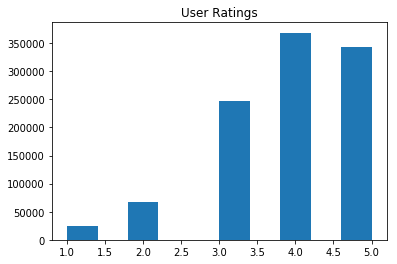

In [12]:
# Distribution of rating

f = plt.figure(1)
plt.hist(ratings_list)
plt.title("User Ratings")

## Create Training Validation and Test Datasets

In [7]:
#data_list, ratings_list = load_df_data(df_bkRatngs)
random.shuffle(data_list)

n_train = int(0.8 * len(data_list))

# split train and test
train_list = data_list[:n_train] 
test_list = data_list[n_train:]

print(len(train_list))
print(len(test_list))

# further split test set into validation set and test set
n_test = len(test_list)
val_list = test_list[:n_test//2]
test_list = test_list[n_test//2:]

random.shuffle(train_list)
random.shuffle(val_list)


print(train_list[:5])

841039
210260
[{'in0': [9154], 'in1': [382], 'label': 4.0}, {'in0': [7716], 'in1': [63], 'label': 5.0}, {'in0': [793], 'in1': [138], 'label': 5.0}, {'in0': [6217], 'in1': [722], 'label': 3.0}, {'in0': [2009], 'in1': [531], 'label': 4.0}]


#### Write the data  in the format required by Object2Vec

The object2vec algorithm is used predict exact ratings of a book by a given user.
We provide the algorithm userID, itemID pairs. For each such pair, we also provide "label" that tells the algorithm whether user and item are similar or not

In [14]:
write_data_list_to_jsonl(copy.deepcopy(train_list), 'train_r.jsonl')
write_data_list_to_jsonl(copy.deepcopy(val_list), 'validation_r.jsonl')

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


## Model Training

Define S3 bucket that hosts the data and model, and upload data to the relevant bucket. Define the paths (on s3) containing training and validation data

In [18]:
bucket = 'ai-in-aws' #Designate your own bucket name
input_prefix = 'object2vec/input'
output_prefix = 'object2vec/output'

In [ ]:
s3_client = boto3.client('s3')
input_paths = {} #initialize dictionary
output_path = os.path.join('s3://', bucket, output_prefix)


for data_name in ['train', 'validation']:
    pre_key = os.path.join(input_prefix, 'rating', f'{data_name}') #F-string: embed python expression inside string literal
    fname = '{}_r.jsonl'.format(data_name)
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    #upload data to S3
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    
    #Create definition of input data; data_path - path containing s3 data
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded {} data to {}'.format(data_name, data_path))
    
print('Trained model will be saved at', output_path)    

##### Get image of ObjectToVec Algorithm

In [9]:
sess = sagemaker.Session()
role = get_execution_role()

#Get docker image for the ObjectToVec algorithm
container = get_image_uri(boto3.Session().region_name, 'object2vec') #input: region name, name of the algorithm

##### Let's define hyperparameters

In [7]:
static_hyperparameters = { 
    "_kvstore": "device", #type of GPU
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    #"dropout": 0.3,
    "bucket_width": 0,
    "early_stopping_patience": 2,
    "early_stopping_tolerance": 0.01,
    #"enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
   #"enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 12347, #number of unique users
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    #"enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 985,  #number of unique books
    "enc_dim": 1024, 
    "epochs": 10,
    #"learning_rate": 0.01,
    "mini_batch_size": 64,
    "mlp_activation": "relu",
    "mlp_dim": 256,
    "mlp_layers": 1,
   # "num_classes": 2, #( 0 or 1)
    "optimizer": "adam",
    #"weight_decay": 1000,
    "output_layer": "mean_squared_error"
}

In [23]:
## get estimator
regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.4xlarge',  #ml.p2.xlarge
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**static_hyperparameters)

## train, tune, and test the model
regressor.fit(input_paths)

2019-08-23 20:02:02 Starting - Starting the training job...
2019-08-23 20:02:03 Starting - Launching requested ML instances......
2019-08-23 20:03:11 Starting - Preparing the instances for training...
2019-08-23 20:03:58 Downloading - Downloading input data
2019-08-23 20:03:58 Training - Downloading the training image......
2019-08-23 20:04:47 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[08/23/2019 20:04:50 INFO 140183440512832] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_storage_type': u'dense', u'enc0_token_embedding_dim

## Model Deployment

In [24]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
regression_model = regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')

In [25]:
# deploy the model
predictor = regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

## Model Evaluation

#### Convert test data in the format required by object2vec

In [8]:
test_data, test_label = data_list_to_inference_format(copy.deepcopy(test_list[:100]), binarize=False)

data_ : [({'in0': [1986], 'in1': [47]}, 4.0), ({'in0': [247], 'in1': [46]}, 3.0), ({'in0': [3892], 'in1': [483]}, 3.0), ({'in0': [11705], 'in1': [56]}, 5.0), ({'in0': [7841], 'in1': [235]}, 3.0), ({'in0': [9778], 'in1': [143]}, 5.0), ({'in0': [2028], 'in1': [895]}, 2.0), ({'in0': [3691], 'in1': [751]}, 4.0), ({'in0': [2174], 'in1': [239]}, 4.0), ({'in0': [4902], 'in1': [459]}, 4.0), ({'in0': [2339], 'in1': [295]}, 5.0), ({'in0': [11118], 'in1': [329]}, 5.0), ({'in0': [10902], 'in1': [839]}, 4.0), ({'in0': [4724], 'in1': [660]}, 5.0), ({'in0': [9074], 'in1': [172]}, 5.0), ({'in0': [8577], 'in1': [389]}, 3.0), ({'in0': [3142], 'in1': [584]}, 5.0), ({'in0': [598], 'in1': [125]}, 4.0), ({'in0': [1850], 'in1': [180]}, 5.0), ({'in0': [11666], 'in1': [186]}, 3.0), ({'in0': [1582], 'in1': [518]}, 4.0), ({'in0': [5594], 'in1': [192]}, 5.0), ({'in0': [6996], 'in1': [646]}, 3.0), ({'in0': [6485], 'in1': [155]}, 4.0), ({'in0': [2451], 'in1': [779]}, 5.0), ({'in0': [6205], 'in1': [123]}, 4.0), ({'i

The below code (cell) is required if you want to run inference separately from the model deployment code - i.e if you cannot run the entire notebook in one go and want to deploy the model as endpoint and come back to it at a later point in time for inference, you can do so.

In [14]:
from sagemaker.predictor import RealTimePredictor, json_serializer, json_deserializer
predictor = RealTimePredictor(endpoint='object2vec-2019-08-23-21-59-03-344', sagemaker_session=sess, serializer=json_serializer,
                                deserializer=json_deserializer,
                        content_type='application/json')


In [21]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(test_data)

print("The mean squared error on test set is %.3f" %get_mse_loss(prediction, test_label))

The mean squared error on test set is 0.110


MSE of 0.110 is better than the baselines: 
Option 1 MSE: 1.13, where predicted book rating is global average book rating across all users
Option 2 MSE: 0.82, where predicted book rating is average book rating by user

#### Baseline  1

Compute average book rating on training dataset and use it as your prediction for books in test dataset

In [22]:
#Option 1
train_label = [row['label'] for row in copy.deepcopy(train_list)]

bs1_prediction = round(np.mean(train_label), 2)
print("The validation mse loss of the Baseline 1 is {}".format(
                                     get_mse_loss(len(test_label)*[bs1_prediction], test_label)))

The validation mse loss of the Baseline 1 is 1.13


In [23]:
#Create user dictionary for users in training dataset
to_users_dict, to_books_dict = jsnl_to_augmented_data_dict(train_list)

In [59]:
#Inspect users dict
to_users_dict

{798: [(7555, 9.0),
  (23166, 8.0),
  (28279, 5.0),
  (14115, 8.0),
  (6695, 8.0),
  (17665, 9.0),
  (3946, 7.0),
  (21806, 8.0),
  (22278, 9.0),
  (19131, 8.0),
  (10368, 8.0),
  (198, 9.0),
  (4950, 9.0),
  (29071, 8.0),
  (27834, 7.0),
  (23461, 8.0),
  (13597, 10.0),
  (26427, 8.0),
  (5400, 10.0),
  (13113, 10.0),
  (10393, 10.0),
  (16708, 8.0),
  (21027, 8.0),
  (9036, 6.0),
  (8710, 9.0),
  (8730, 5.0),
  (9888, 8.0),
  (23154, 5.0),
  (12637, 9.0),
  (13475, 6.0),
  (9626, 6.0),
  (4994, 9.0),
  (15229, 9.0),
  (22751, 9.0),
  (13177, 9.0),
  (29302, 9.0),
  (19642, 5.0),
  (2813, 8.0),
  (21372, 9.0),
  (5333, 8.0),
  (972, 10.0),
  (1075, 6.0),
  (23822, 8.0),
  (12099, 10.0),
  (11760, 9.0),
  (15637, 8.0),
  (25098, 8.0),
  (176, 8.0),
  (15991, 10.0),
  (5935, 7.0),
  (10255, 9.0),
  (16591, 9.0),
  (7823, 9.0),
  (7029, 9.0),
  (26007, 9.0),
  (9300, 10.0),
  (18991, 10.0),
  (5418, 10.0),
  (23976, 6.0),
  (4004, 9.0),
  (3701, 7.0),
  (20049, 10.0),
  (22897, 6.0),
  (

#### Baseline  2

Instead of global average book rating, let's use average book rating by user. To illustrate, for a given user, we will take average book rating across all the books he rated. We will use this rating as our prediction, and compare it to the label (actual value). 

In [24]:
#Determine how many test users are in training dataset
#We can only compute average book rating by user, only if the user is in training dataset

dftest = pd.DataFrame()
dftrain = pd.DataFrame()

#test
tusrlist = [] 
for row in test_list:
    tusrlist.append(row['in0'][0])

#train
tr_usrlist = []

for row in train_list:
    tr_usrlist.append(row['in0'][0])
    
dftest = pd.DataFrame({'userID':tusrlist})
dftrain = pd.DataFrame({'userID':tr_usrlist})

dfmatch = dftest[dftest['userID'].isin(dftrain['userID'])]

len(dftest['userID'].unique())
#5,631 users are in test dataset

len(dftrain['userID'].unique())
#9,489 users are in train dataset

len(dfmatch['userID'].unique())
# Out of 5,631 users in test dataset, 5,541 users only are in training set


12318

In [25]:
#Option 2:
def bs2_predictor(test_data, user_dict):
    test_data = copy.deepcopy(test_data['instances'])
    predictions = list()
    for row in test_data:
        userID = int(row["in0"][0])
        # predict book rating based on local average of user's prediction
        if userID in user_dict:
            local_books, local_ratings = zip(*user_dict[userID])
            local_ratings = [float(score) for score in local_ratings]
            predictions.append(np.mean(local_ratings))
        else:
            #For users not in training set, let's user global average rating
            predictions.append(bs1_prediction)
            #print ("predictions per user", predictions[-1])    
    return predictions

In [26]:
bs2_prediction = bs2_predictor(test_data, to_users_dict)

print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, test_label)))

The validation loss of the Baseline 2 (user-based rating average) is 0.82


## Hyperparameter Tuning

In [11]:
from time import gmtime, strftime 
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

tuning_job_name = "object2vec-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

hyperparameters_ranges = { "learning_rate": ContinuousParameter(0.0004, 0.02),
                            "dropout": ContinuousParameter(0.0, 0.4),  
                            "enc_dim": IntegerParameter(1000, 2000),
                            "mlp_dim": IntegerParameter(256, 500),
                            "weight_decay": ContinuousParameter(0, 300) }     

objective_metric_name = 'validation:mean_squared_error'


regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.4xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**static_hyperparameters)

tuner = HyperparameterTuner(regressor, 
                            objective_metric_name, 
                            hyperparameters_ranges,
                            objective_type='Minimize', 
                            max_jobs=8, 
                            max_parallel_jobs=2,
                            strategy='Random')

In [12]:
tuner.fit({'train': input_paths['train'], 'validation': input_paths['validation']}, 
          job_name=tuning_job_name, include_cls_metadata=False)
tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
objTunerAnltcs = tuner.analytics()

In [16]:
#Review summary of all the jobs executed
objTunerAnltcs.training_job_summaries(force_refresh=False)

# Although we have triggered the execution of 8 training jobs, we stopped the execution of last 2, since the MSE was not decreasing any further

[{'TrainingJobName': 'object2vec-job-03-23-56-15-008-cd9a2e4a',
  'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:413491515223:training-job/object2vec-job-03-23-56-15-008-cd9a2e4a',
  'CreationTime': datetime.datetime(2019, 9, 4, 3, 52, 5, tzinfo=tzlocal()),
  'TrainingStartTime': datetime.datetime(2019, 9, 4, 3, 53, 56, tzinfo=tzlocal()),
  'TrainingEndTime': datetime.datetime(2019, 9, 4, 4, 6, 30, tzinfo=tzlocal()),
  'TrainingJobStatus': 'Stopped',
  'TunedHyperParameters': {'dropout': '0.25486129554078174',
   'enc_dim': '1039',
   'learning_rate': '0.015752702839978403',
   'mlp_dim': '327',
   'weight_decay': '295.169871054492'},
  'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mean_squared_error',
   'Value': 1.025862693786621},
  'ObjectiveStatus': 'Succeeded'},
 {'TrainingJobName': 'object2vec-job-03-23-56-15-007-09e28355',
  'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:413491515223:training-job/object2vec-job-03-23-56-15-007-09e28355',
  'CreationT

In [17]:
dfTuning = objTunerAnltcs.dataframe(force_refresh=False)

In [18]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

# Now plot it
p = figure(plot_width=500, plot_height=500, 
               x_axis_type = 'datetime')
p.circle(source=dfTuning, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [18]:
dfTuning[2:]

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,dropout,enc_dim,learning_rate,mlp_dim,weight_decay
2,1.026153,4785.0,2019-09-04 03:51:47+00:00,object2vec-job-03-23-56-15-006-2015ad51,Completed,2019-09-04 02:32:02+00:00,0.132256,1317.0,0.008378,274.0,29.157081
3,1.025876,5037.0,2019-09-04 03:43:07+00:00,object2vec-job-03-23-56-15-005-37134e77,Completed,2019-09-04 02:19:10+00:00,0.152922,1135.0,0.002945,268.0,52.942607
4,1.025938,3911.0,2019-09-04 02:14:37+00:00,object2vec-job-03-23-56-15-004-09e888f6,Completed,2019-09-04 01:09:26+00:00,0.092191,1626.0,0.014294,485.0,147.279160
5,1.026456,4739.0,2019-09-04 02:27:33+00:00,object2vec-job-03-23-56-15-003-07287071,Completed,2019-09-04 01:08:34+00:00,0.073076,1978.0,0.007386,368.0,182.029502
6,1.025840,3805.0,2019-09-04 01:01:53+00:00,object2vec-job-03-23-56-15-002-19f355c0,Completed,2019-09-03 23:58:28+00:00,0.269199,1694.0,0.016486,352.0,75.028273
7,1.025924,3815.0,2019-09-04 01:01:33+00:00,object2vec-job-03-23-56-15-001-bb7f5c71,Completed,2019-09-03 23:57:58+00:00,0.287678,1613.0,0.009053,269.0,279.837002


In [19]:
# How does MSE vary with encoder dimension
hover = HoverTool(
        tooltips=[
            ("Encoder Dim", "@enc_dim"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='enc_dim', y='FinalObjectiveValue')
show(p)



In [20]:
# How does MSE vary with mlp dimension
hover = HoverTool(
        tooltips=[
            ("MLP Dim", "@mlp_dim"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='mlp_dim', y='FinalObjectiveValue')
show(p)



In [21]:
# How does MSE vary with learning date

hover = HoverTool(
        tooltips=[
            ("Learning Rate", "@learning_rate"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='learning_rate', y='FinalObjectiveValue')
show(p)



In [22]:
# How does MSE vary with weight decay

hover = HoverTool(
        tooltips=[
            ("Weight Decay", "@weight_decay"),
            ("MSE", "@FinalObjectiveValue"),
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
               x_axis_type = 'linear')
p.circle(source=dfTuning, x='weight_decay', y='FinalObjectiveValue')
show(p)


### Let's train the model with new hyperparameters

In [24]:
new_static_hyperparameters = { 
    "dropout": 0.3,
    "bucket_width": 0,
    "early_stopping_patience": 2,
    "early_stopping_tolerance": 0.01,
    #"enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
   #"enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 12347, #number of unique users
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    #"enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 985,  #number of unique books
    "enc_dim": 1024, 
    "epochs": 10,
    "learning_rate": 0.016,
    "mini_batch_size": 64,
    "mlp_activation": "relu",
    "mlp_dim": 352,
    "mlp_layers": 1,
   # "num_classes": 2, #( 0 or 1)
    "optimizer": "adam",
    "weight_decay": 75,
    "output_layer": "mean_squared_error"
}

In [ ]:
## get estimator
new_regressor = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.4xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
new_regressor.set_hyperparameters(**new_static_hyperparameters)

## train, tune, and test the model
new_regressor.fit(input_paths)

### Deploy the optimized model

In [26]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
new_regression_model = new_regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')
# deploy the model
new_predictor = new_regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------------------------------!

In [27]:
# Send data to the endpoint to get predictions
new_prediction = new_predictor.predict(test_data)

print("The mean squared error on test set is %.3f" %get_mse_loss(new_prediction, test_label))

The mean squared error on test set is 0.820
